In [28]:
import sys; sys.path.extend(['../'])
%pylab inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pylab as pl
import pandas as pd
import datetime
from src import stanio
from matplotlib import rcParams
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


All the data frames we're loading should be set to start on March 10th, so we'll use a short function for setting the index like that, and another to load, fix the dates and filter columns

In [2]:
# start with March
t0 = datetime.datetime(year=2020, month=3, day=1)

def fix_t0(df, date_key):
    df = df.set_index(df[date_key])
    df = df.set_index((df.index - t0).days)
    return df

def load_data(csv_fname, date_key, re_cols):
    df = pd.read_csv(csv_fname, parse_dates=[date_key])
    df = fix_t0(df, date_key)
    df = df.filter(regex=re_cols)
    return df

Now let's load the ICL estimates for Germany & Denmark, Google mobility data and COSMO data:

In [3]:
r_de = load_data("../data/processed/germany_imperial_college_sir.csv", 
                 "date",
                 "^mean_time_varying_reproduction_number")
r_dk = load_data("../data/processed/denmark_imperial_college_sir.csv", 
                 "date",
                 "^mean_time_varying_reproduction_number")

m_de = load_data("../data/processed/germany_google_mobility_report.csv", "date", "retail")/100
m_dk = load_data("../data/processed/denmark_google_mobility_report.csv", "date", "retail")/100

c_de = load_data("../data/processed/germany_cosmo_phi.csv", "date", "phi")
c_dk = load_data("../data/processed/denmark_cosmo_phi.csv", "date", "phi")

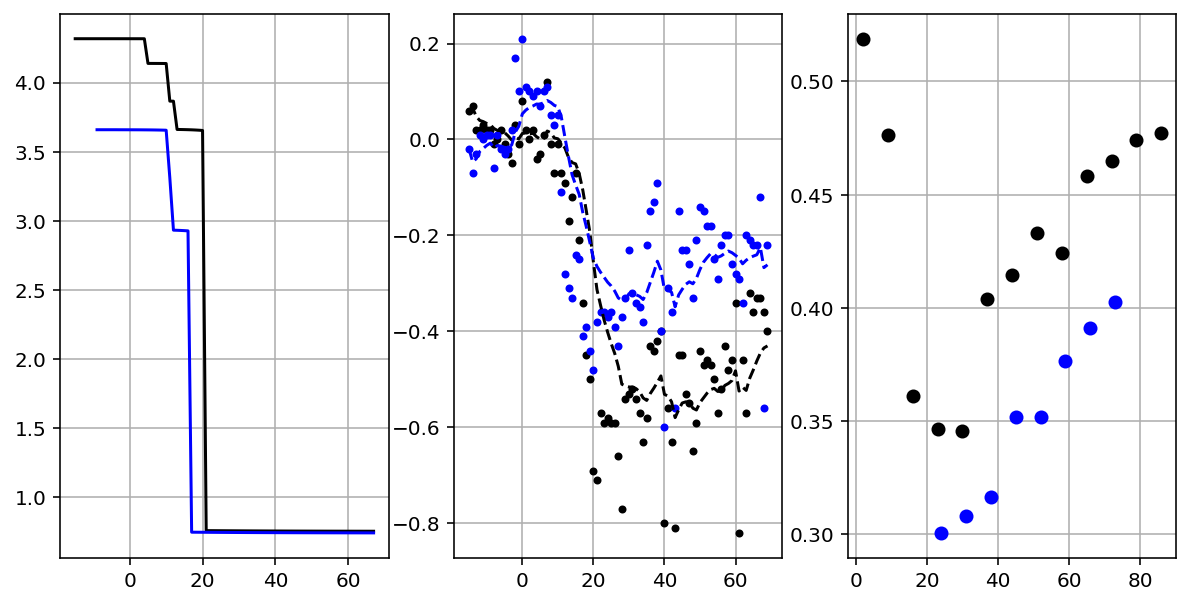

In [4]:
figure(figsize(10, 5))
subplot(131); plot(r_de, 'k'); plot(r_dk, 'b'); grid(1)
subplot(132); plot(m_de, 'k.'); plot(m_dk, 'b.'); plot(m_de.ewm(com=7).mean(), 'k--'); plot(m_dk.ewm(com=7).mean(), 'b--'), grid(1)
subplot(133); plot(c_de, 'ko'); plot(c_dk, 'bo'); grid(1)

In [5]:
R = np.c_[r_de.loc[0:65],r_dk.loc[0:65]]
M = np.c_[m_de.ewm(com=7).mean().loc[0:65],m_dk.ewm(com=7).mean().loc[0:65]]
M -= M.max(axis=0)

$ \dot{\beta} = \beta_0 - \beta(t) + a M(t) - J_s - \gamma (\phi(t) - \phi_0) $

$ \dot{\phi} = -(\phi(t) - \phi_0 + h M(t)) - c \tanh(2 u(t)) $

$  \dot{u} = -\Gamma (\beta - \beta_0) $

- $h=0.1$
- $\sigma=30$

(0, 65)

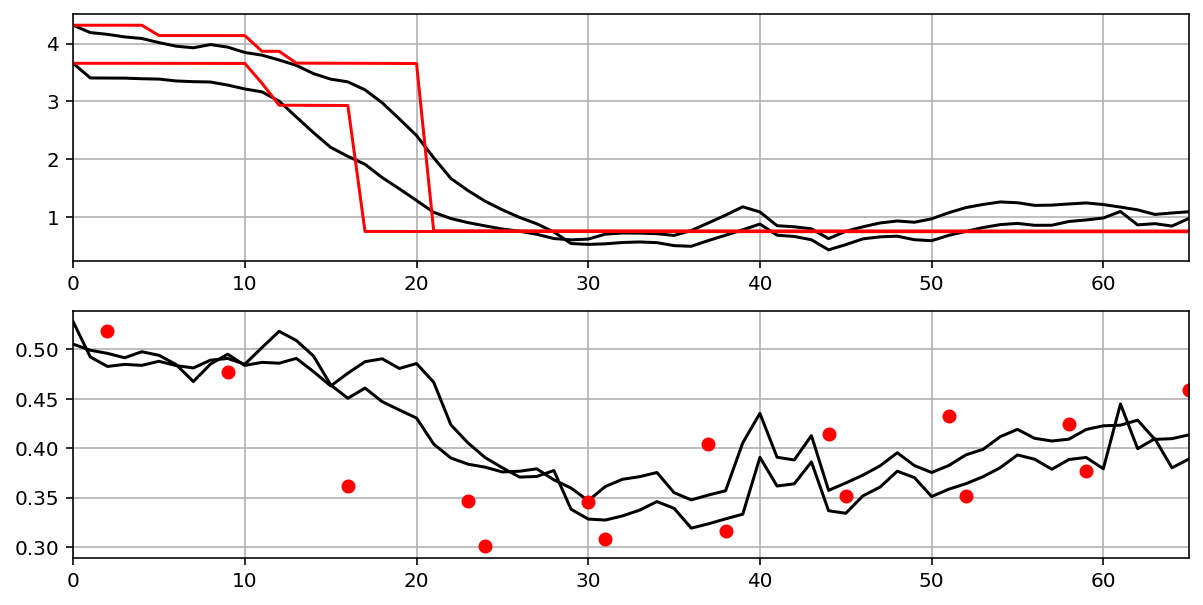

In [11]:
alpha = 1.0 / 14.0
b = [R[0] * alpha]
p = [np.r_[0.5, 0.4]]
u = [np.r_[0.0, 0.0]]
for t, M_t in enumerate(M):
    Js = t*0.13/65 # 
    Js = .4/2*(1-cos((2*pi*(t - 15 + 29 + 31))/365))
    #db = (b[0] + np.r_[0.5,0.6]*M_t*0.8 - Js + np.r_[0.15,0.05]*(p[-1]-p[0])) - b[-1]
    db = (b[0] + (0.4*M_t+0.05) - Js - 0.3*(p[-1] - p[0])) - b[-1]
    dp = -(p[-1] - p[0] + 0.1*M[min(t,65)]) - tanh(2*u[-1])
    du = (b[0] - b[-1])
    b1 = b[-1] + db
    b1[b1<0] = 0
    b.append(b1)
    p.append(p[-1] + dp)
    u.append(u[-1] + du/30)
b = np.array(b)
p = np.array(p)
u = np.array(u)

subplot(211); plot(b/alpha, 'k'); plot(R, 'r'); grid(1); xlim([0,65])
subplot(212); plot(diff(p,axis=0)[0:]*10+.5, 'k');
plot(c_de, 'ro'); plot(c_dk, 'ro'); grid(1); xlim([0,65])

Generate Stan data files for both countries

In [9]:
stanio.rdump(
    "SDEs-DE.R",
    {
        "nt": len(R),
        "r": R[:, 0],
        "m": M[:, 0],
        "nC": 8,
        "iC": np.r_[:8]*7+c_de.index[0]+7,
        "C": np.r_[c_de][:8,0],
    })

stanio.rdump(
    "SDEs-DK.R",
    {
        "nt": len(R),
        "r": R[:, 1],
        "m": M[:, 1],
        "nC": 5,
        "iC": np.r_[:5]*7+c_dk.index[0]+7,
        "C": np.r_[c_dk][:5,0]
    })

In [82]:
!make -C ~/crypt/cmdstan-2.22.1 $PWD/../src/SDEs
!rm *.csv
!for i in {1..4}; do ../src/SDEs sample data file=SDEs-DE.R output refresh=1000 file=de.$i.csv; done
!for i in {1..4}; do ../src/SDEs sample data file=SDEs-DK.R output refresh=1000 file=dk.$i.csv; done
#!../src/SDEs sample data file=SDEs-DK.R output file=dk.csv
!/Users/duke/crypt/cmdstan-2.22.1/bin/diagnose de.*.csv
!/Users/duke/crypt/cmdstan-2.22.1/bin/diagnose dk.*.csv


--- Translating Stan model to C++ code ---
bin/stanc  --o=/Volumes/crypt/CovidH_TNG/notebooks/../src/SDEs.hpp /Volumes/crypt/CovidH_TNG/notebooks/../src/SDEs.stan
clang++ -std=c++1y -Wno-unknown-warning-option -Wno-tautological-compare -Wno-sign-compare -D_REENTRANT       -I stan/lib/stan_math/lib/tbb_2019_U8/include -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.3 -I stan/lib/stan_math/lib/boost_1.72.0 -I stan/lib/stan_math/lib/sundials_4.1.0/include    -DBOOST_DISABLE_ASSERTS      -c -MT /Volumes/crypt/CovidH_TNG/notebooks/../src/SDEs.o -MT /Volumes/crypt/CovidH_TNG/notebooks/../src/SDEs -include /Volumes/crypt/CovidH_TNG/notebooks/../src/SDEs.hpp -include src/cmdstan/main.cpp -MM -E -MG -MP -MF /Volumes/crypt/CovidH_TNG/notebooks/../src/SDEs.d /Volumes/crypt/CovidH_TNG/notebooks/../src/SDEs.hpp

--- Compiling, linking C++ code ---
clang++ -std=c++1y -Wno-unknown-warning-option -Wno-tautological-compare -Wno-sign-compare -D_

Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 1.81087 seconds (Warm-up)
               1.5285 seconds (Sampling)
               3.33937 seconds (Total)

method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = hmc (Default)
      hmc
        engine = nuts (Default)
          nuts
            max_depth = 10 (Default)
        metric = diag_e (Default)
        metric_file =  (Default)
        stepsize = 1 (Default)
        stepsize_jitter = 0 (Default)
id = 0 (Default)
data
  file = SDEs-DK.R
init = 2 (Default)
random

In [83]:
de = stanio.parse_csv("de.*.csv")
dk = stanio.parse_csv("dk.*.csv")

In [84]:
def prior(mu,sd):
    l, r = xlim()
    x = np.r_[l:r:100j]
    plot(x, stats.norm.pdf(x, mu, sd), 'k', alpha=0.3, linewidth=2)

de g [0.17501132 0.2101455  0.2551918 ]
dk g [0.18247025 0.2334695  0.30127265]
de g=0 p= 1.1147017116342298e-22
dk g=0 p= 7.045742279890399e-13
de G [1.25196625 1.40048    1.5372005 ]
dk G [0.87624495 1.03678    1.208986  ]
de c [0.9552328 1.11062   1.2842615]
dk c [0.83592    1.01629    1.20654325]


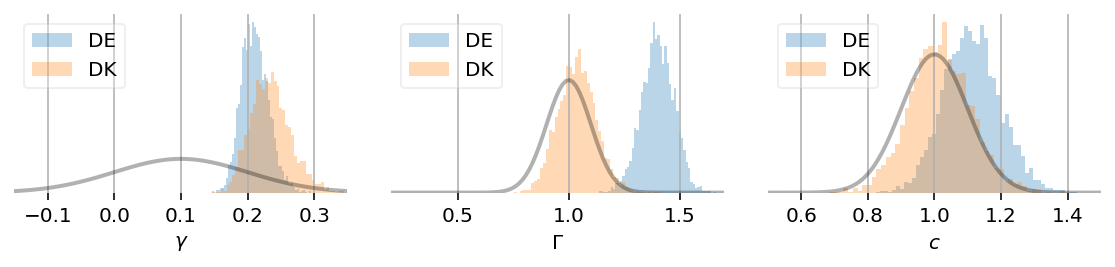

In [89]:
figure(figsize=(8,2))
for i, (k,l,xl,p) in enumerate(zip(['g', 'G', 'c'],
                                   [r'$\gamma$', r'$\Gamma$', r'$c$'],
                                   [(-0.15,0.35), (0.2,1.7), (0.5,1.5)],
                                   [(0.1,0.1), (1,0.1), (1,0.1)]
                                  )):
    ax = subplot(1,3,i+1,frameon=False)
    hist(de[k], 50, alpha=0.3, density=True)
    hist(dk[k], 50, alpha=0.3, density=True)
    print(f'de {k}', np.percentile(de[k], [2.5, 50, 97.5]))
    print(f'dk {k}', np.percentile(dk[k], [2.5, 50, 97.5]))
    if k=='g':
        print('de g=0 p=',stats.norm.pdf(0,de[k].mean(),de[k].std()))
        print('dk g=0 p=',stats.norm.pdf(0,dk[k].mean(),dk[k].std()))
    grid(1)
    legend((f'DE', f'DK'), loc='upper left', fancybox=True, framealpha=0.3)
    xlabel(l)
    ax.yaxis.set_visible(False)
    xlim(xl)
    prior(*p)
tight_layout()